## Setup

Load libraries

In [1]:
import datetime
from snowai.density import (
    JonasDensity, 
    PistochiDensity, 
    SturmDensity,
    MachineLearningDensity
)

from snowai.utils import ConvertData, clean_cache
from sklearn.metrics import root_mean_squared_error

## Download Data

We will download some SNOTEL data using the `metloom API`. Install `metloom` using:

```bash
pip install metloom
```

In [2]:
try:
    from metloom.pointdata import SnotelPointData
except ImportError:
    !pip install metloom

In [3]:
# Let's select banner summit
pt = SnotelPointData("312:ID:SNTL", "Banner Summit")

# start data and end date
start_date = datetime.datetime(2024, 2, 1)
end_date = datetime.datetime(2024, 2, 29)


# Notice this is a list
variables = [
    pt.ALLOWED_VARIABLES.SWE,
    pt.ALLOWED_VARIABLES.TEMPMIN,
    pt.ALLOWED_VARIABLES.TEMPMAX,
    pt.ALLOWED_VARIABLES.TEMPAVG,
    pt.ALLOWED_VARIABLES.SNOWDEPTH,
]

# request the data
df = pt.get_daily_data(start_date, end_date, variables)
df.head(3)

,,geometry,SWE,SWE_units,MIN AIR TEMP,MIN AIR TEMP_units,MAX AIR TEMP,MAX AIR TEMP_units,AVG AIR TEMP,AVG AIR TEMP_units,SNOWDEPTH,SNOWDEPTH_units,datasource
datetime,site,,,,,,,,,,,,
2024-02-01 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),10.5,in,25.34,degF,36.86,degF,31.82,degF,40.0,in,NRCS
2024-02-02 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),10.7,in,25.88,degF,31.46,degF,28.76,degF,40.0,in,NRCS
2024-02-03 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),11.0,in,22.10,degF,30.56,degF,25.70,degF,43.0,in,NRCS


## Data Cleaning

We will do the following:

* Variable selection: we will select the variables of interest.
* Feature engineering:
    - we will convert inches to meters (all methods accepts snow depth and elevation in meters).
    - we will convert temperatures to degree Celcius.
    - we will get snow class (Sturm and ML models need Snow Depth).

Note: if you decide to convert lats and lons to snow class using `ConvertData.get_snow_class`, the code will prompt you to download the snow class raster. You can also pass your own raster.

In [4]:
clean_data=(
    df
    .reset_index()
   .filter(items=["datetime", "geometry", "MIN AIR TEMP", "MAX AIR TEMP", "AVG AIR TEMP", "SNOWDEPTH", "SWE"])
    .assign(
        Elevation_m=lambda x: ConvertData.inches_to_metric(x.geometry.map(lambda x: x.coords[0][2]), unit="meters"),
        Latitude=lambda x: x.geometry.map(lambda x: x.coords[0][1]),
        Longitude=lambda x: x.geometry.map(lambda x: x.coords[0][0]),
        TAVG_degC=lambda x: ConvertData.fah_to_cel(x["AVG AIR TEMP"]),
        TMIN_degC=lambda x: ConvertData.fah_to_cel(x["MIN AIR TEMP"]),
        TMAX_degC=lambda x: ConvertData.fah_to_cel(x["MAX AIR TEMP"]),
        Month=lambda x: x.datetime.dt.month,
        Snow_Depth_cm=lambda x: ConvertData.inches_to_metric(x["SNOWDEPTH"], unit="cm"),
        Snow_Class=lambda x: ConvertData.get_snow_class(lons=x.Longitude, lats=x.Latitude, raster=None),
        Snow_Depth_m=lambda x: ConvertData.inches_to_metric(x["SNOWDEPTH"], unit="meters"),
        SWE_cm=lambda x: ConvertData.inches_to_metric(x["SWE"], unit="cm"),
        Snow_Density_gcm=lambda x: x.SWE_cm / x.Snow_Depth_cm

    )
    .drop(columns=[
        "geometry", "AVG AIR TEMP", 
        "MIN AIR TEMP", "MAX AIR TEMP", 
        "SNOWDEPTH", "Snow_Depth_cm",
        "Latitude", "Longitude"
    ])
)

clean_data.head(3)

The Snow Classification raster needs to be downloaded.
This file is approximately 1.9 GB in size and will be stored at: /Users/ibrahim/Library/Caches/CroGarsAI/SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc


Downloading...
From (original): https://drive.google.com/uc?id=1yhthVbkdBNm_pL5wl5YlwNaKN96iUGa8
From (redirected): https://drive.google.com/uc?id=1yhthVbkdBNm_pL5wl5YlwNaKN96iUGa8&confirm=t&uuid=52c46b59-7279-4fef-8373-ed7e9b6a2a9d
To: /Users/ibrahim/Library/Caches/CroGarsAI/SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc
100%|██████████| 1.98G/1.98G [01:42<00:00, 19.4MB/s]


Download complete.


,datetime,SWE,Elevation_m,TAVG_degC,TMIN_degC,TMAX_degC,Month,Snow_Class,Snow_Depth_m,SWE_cm,Snow_Density_gcm
0,2024-02-01 08:00:00+00:00,10.5,178.816,-0.1,-3.7,2.7,2,alpine,1.0160,26.670,0.262500
1,2024-02-02 08:00:00+00:00,10.7,178.816,-1.8,-3.4,-0.3,2,alpine,1.0160,27.178,0.267500
2,2024-02-03 08:00:00+00:00,11.0,178.816,-3.5,-5.5,-0.8,2,alpine,1.0922,27.940,0.255814


In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   datetime          29 non-null     datetime64[ns, UTC]
 1   SWE               29 non-null     float64            
 2   Elevation_m       29 non-null     float64            
 3   TAVG_degC         29 non-null     float64            
 4   TMIN_degC         29 non-null     float64            
 5   TMAX_degC         29 non-null     float64            
 6   Month             29 non-null     int32              
 7   Snow_Class        29 non-null     object             
 8   Snow_Depth_m      29 non-null     float64            
 9   SWE_cm            29 non-null     float64            
 10  Snow_Density_gcm  29 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(8), int32(1), object(1)
memory usage: 2.5+ KB


## Predict Snow Density

Note that all models return snow density in $gcm^{-3}$.

In [6]:
preds=(
    clean_data
    .assign(
        Jonas_Density=lambda x: JonasDensity().predict(data=x, snow_depth='Snow_Depth_m', month='Month', elevation='Elevation_m'),
        Pistochi_Density=lambda x: PistochiDensity().predict(data=x, DOY='datetime'),
        Sturm_Density=lambda x: SturmDensity().predict(data=x, snow_depth='Snow_Depth_m', DOY='datetime', snow_class='Snow_Class'),
        ML_Density=lambda x: MachineLearningDensity().predict(data=x, snow_depth='Snow_Depth_m', DOY='datetime', snow_class='Snow_Class', elevation='Elevation_m', tavg='TAVG_degC', tmin='TMIN_degC', tmax='TMAX_degC')
    )
    .drop(columns=[
        "SWE",
        "Elevation_m", 
        "TAVG_degC",
        "TMIN_degC", 
        "TMAX_degC", 
        "Month", 
        "Snow_Class"
    ])
 )

preds.head(3)

The Machine Learning Wegiths needs to be downloaded.
This file is approximately 180 MB in size and will be stored at: /Users/ibrahim/Library/Caches/CroGarsAI/density_model.ubj


Downloading...
From (original): https://drive.google.com/uc?id=1tLHRR7wuI33FfrjBTBK_-KyXHnT2jfat
From (redirected): https://drive.google.com/uc?id=1tLHRR7wuI33FfrjBTBK_-KyXHnT2jfat&confirm=t&uuid=dc3addb6-4284-416d-b5a4-6e9c830344bb
To: /Users/ibrahim/Library/Caches/CroGarsAI/density_model.ubj
100%|██████████| 185M/185M [00:09<00:00, 19.4MB/s] 


Download complete.


,datetime,Snow_Depth_m,SWE_cm,Snow_Density_gcm,Jonas_Density,Pistochi_Density,Sturm_Density,ML_Density
0,2024-02-01 08:00:00+00:00,1.0160,26.670,0.262500,0.288144,0.354,0.304492,0.246541
1,2024-02-02 08:00:00+00:00,1.0160,27.178,0.267500,0.288144,0.355,0.305603,0.245297
2,2024-02-03 08:00:00+00:00,1.0922,27.940,0.255814,0.288830,0.356,0.309357,0.237329


## Model Evaluation

In [7]:
print(f"Jonas RMSE: {root_mean_squared_error(preds.Snow_Density_gcm, preds.Jonas_Density):.3}")
print(f"Pistochi RMSE: {root_mean_squared_error(preds.Snow_Density_gcm, preds.Pistochi_Density):.3}")
print(f"Sturm RMSE: {root_mean_squared_error(preds.Snow_Density_gcm, preds.Sturm_Density):.3}")
print(f"ML RMSE: {root_mean_squared_error(preds.Snow_Density_gcm, preds.ML_Density):.3}")

Jonas RMSE: 0.0489
Pistochi RMSE: 0.125
Sturm RMSE: 0.0881
ML RMSE: 0.0133


## Some Plots

In [ ]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib

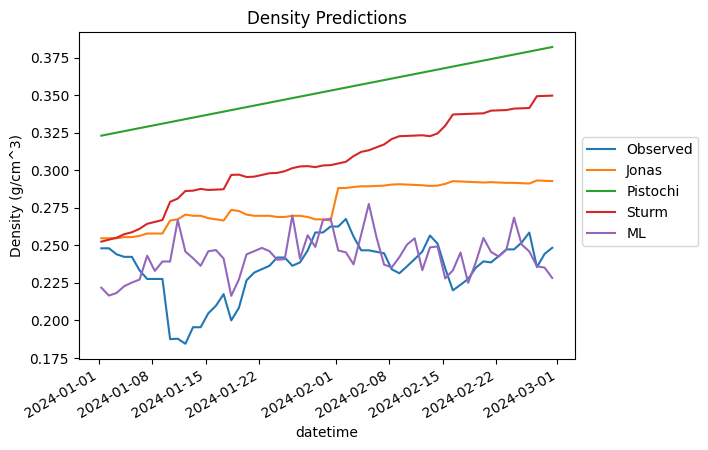

In [21]:
(
    preds
    .set_index("datetime")
    .plot(
        y=["Snow_Density_gcm", "Jonas_Density", "Pistochi_Density", "Sturm_Density", "ML_Density"],
        title="Density Predictions",
        ylabel="Density (g/cm^3)",
    )
)

plt.legend(["Observed", "Jonas", "Pistochi", "Sturm", "ML"],  bbox_to_anchor=(1, 0.7))
plt.show()

* The ML model outperforms the statistical models here. We can also fine tune the ML model on this new data and we might get a better result. This functionality will be added in the future.

## Optionally Delete Downloaded Models

In [32]:
clean_cache(filename='snow_class')
clean_cache(filename='density')

Cleared cached file at /Users/ibrahim/Library/Caches/CroGarsAI/SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc
Cleared cached file at /Users/ibrahim/Library/Caches/CroGarsAI/density_model.ubj
